In [1]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from docplex.mp.model import Model
from kaleidoscope.interactive import bloch_sphere
from matplotlib.colors import LinearSegmentedColormap, rgb2hex
from qiskit.circuit import ClassicalRegister, QuantumRegister, QuantumCircuit, ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator, Sampler, BackendEstimator, BackendSampler
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit_aer import Aer, AerSimulator
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE, QAOA
from qiskit_algorithms.optimizers import COBYLA, SLSQP, SPSA
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

In [ ]:
#Ele faz uma tranformação de QUBO para Ising pois fica mais facil de se entender
#Hamiltoniana = para ver a energia de um sistema 
#A menor energia de um estado físico

In [ ]:
#Variational Quantum Eigensolver - VQE = nada mais é do que a implementação do princípio variacional na computação quântica. 


In [2]:
converter = QuadraticProgramToQubo()
numpy_solver = NumPyMinimumEigensolver()

In [3]:
#Expressão lieral da função de custo
def cost_function(theta: float) -> float:

    return (np.cos(theta/2))**2 - (np.sin(theta/2))**2

theta_values = np.linspace(0, 2*np.pi, 100).tolist()
expectation_values_z = [cost_function(theta=theta) for theta in theta_values]

In [4]:
#Valor minimo
min(expectation_values_z)

-0.9994965423831852

In [6]:
#Angulo associado ao valor minimo 
idx = expectation_values_z.index(min(expectation_values_z))
angulo = np.linspace(0, 2*np.pi, 100).tolist()[idx]
print(angulo)

3.1098593944626236


In [7]:
#Visualização do comportamneto da função de custo 
px.line(x=theta_values, y=expectation_values_z, labels={"y": "Energia", "x": "theta"})

In [8]:
#Otimizando a função de custo com o auxilio do scipy através da expressão literal 
#Definindo os bounds e o ponto inicialda otimização 
bounds = [(-np.pi, np.pi)]
x0 = [np.random.random()]
resultado = scipy.optimize.minimize(fun=cost_function, x0=x0, bounds=bounds, method="SLSQP")

In [9]:
#Esse x é o teta que a gente já queria a resposta 
resultado

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0
       x: [ 3.142e+00]
     nit: 3
     jac: [-7.451e-09]
    nfev: 6
    njev: 3

In [10]:
#Formalismo quadratico = produto matricial
Z = np.array([[1, 0], [0, -1]])

def objective(theta) -> float:

    psi = np.array([np.cos(theta/2), np.sin(theta/2)])
    cost_function_value = psi.T@Z@psi

    return cost_function_value

In [11]:
ounds = [(-np.pi, np.pi)]
x0 = [np.random.random()]
resultado = scipy.optimize.minimize(fun=objective, x0=x0, bounds=bounds, method="SLSQP")

In [12]:
#Mesmo resultado 
resultado

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0
       x: [ 3.142e+00]
     nit: 3
     jac: [-7.451e-09]
    nfev: 6
    njev: 3

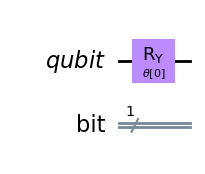

In [13]:
#Mostrando no circuito 
qubit = QuantumRegister(size=1, name="qubit")
bit = ClassicalRegister(size=1, name="bit")
theta = ParameterVector(name=r"$\theta$", length=1)
qc = QuantumCircuit(qubit, bit)
qc.ry(theta=theta[0], qubit=qubit)
qc.draw(output="mpl", style="clifford")

In [14]:
#Atribuindo um valor aleatorio 
qc = qc.assign_parameters([np.random.random()*np.pi])

In [15]:
sv = Statevector(qc)

bloch_sphere(vectors=sv)

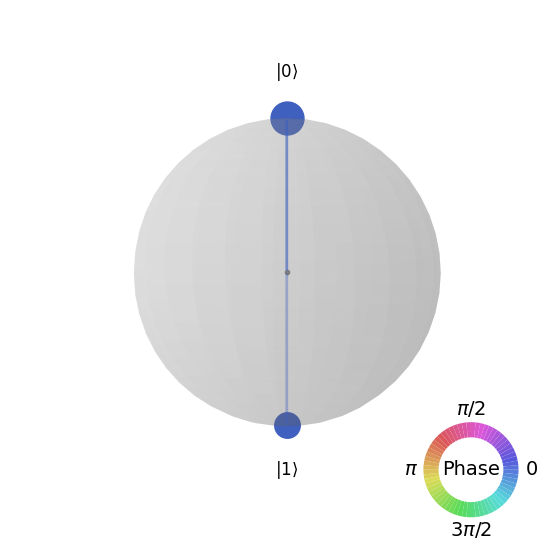

In [16]:
plot_state_qsphere(sv)

In [17]:
qc.measure(qubit=qubit, cbit=bit)
backend = AerSimulator()
resultado = backend.run(qc, shots=1024).result()
counts = resultado.get_counts()

In [18]:
counts

{'0': 645, '1': 379}

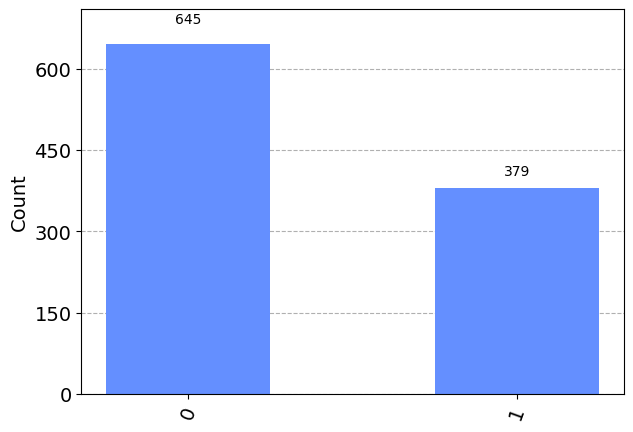

In [19]:
plot_histogram(counts)

In [20]:
prob_0 = counts["0"]/1024
print(prob_0)

0.6298828125


In [21]:
prob_1 = counts["1"]/1024
print(prob_1)

0.3701171875


In [22]:
prob_0 + prob_1

1.0

In [23]:
#Definindo a função objetiva com o circuito para extrair a probabilidade
def objective_circuito(x) -> float:

    shots = 1024
    qubit = QuantumRegister(size=1, name="qubit")
    bit = ClassicalRegister(size=1, name="bit")
    theta = ParameterVector(name=r"$\theta$", length=1)
    qc = QuantumCircuit(qubit, bit)
    qc.ry(theta=theta[0], qubit=qubit)
    qc.measure(qubit=qubit, cbit=bit)
    qc = qc.assign_parameters(x)
    backend = AerSimulator()
    resultado = backend.run(qc, shots=shots).result()
    counts = resultado.get_counts()
    try:
        prob_0 = counts["0"]/shots
    except:
        prob_0 = 0
    try:
        prob_1 = counts["1"]/shots
    except:
        prob_1 = 0
    
    psi = np.array([np.sqrt(prob_0), np.sqrt(prob_1)])
    cost_function_value = psi.T@Z@psi

    return cost_function_value

In [24]:
callback_list = []

def callback_func(theta) -> None:
    callback_list.append((theta[0], objective_circuito(x=theta)))

x0 = [np.random.random()]
resultado = scipy.optimize.minimize(fun=objective_circuito, x0=x0, bounds=None, method="cobyla", callback=callback_func)

In [25]:
resultado

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0
       x: [ 3.167e+00]
    nfev: 12
   maxcv: 0.0

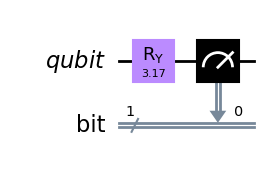

In [26]:
qubit = QuantumRegister(size=1, name="qubit")
bit = ClassicalRegister(size=1, name="bit")
theta = ParameterVector(name=r"$\theta$", length=1)
qc = QuantumCircuit(qubit, bit)
qc.ry(theta=theta[0], qubit=qubit)
qc.measure(qubit=qubit, cbit=bit)
qc = qc.assign_parameters(resultado.x)
qc.draw(output="mpl", style="clifford")

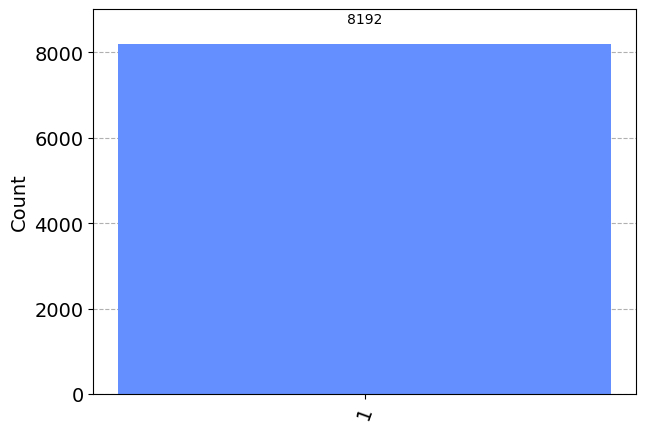

In [27]:
backend = AerSimulator()
resultado = backend.run(qc, shots=8192).result()
counts = resultado.get_counts()
plot_histogram(counts)

In [28]:
#Valor do angulo e da função objetiva
callback_list

[(1.7921986757697574, -0.22070312500000006),
 (2.7921986757697574, -0.9335937500000001),
 (3.7921986757697574, -0.7851562500000001),
 (3.2921986757697574, -0.9843750000000001),
 (3.5421986757697574, -0.9218750000000001),
 (3.1671986757697574, -1.0),
 (3.0421986757697574, -0.9921874999999999),
 (3.1046986757697574, -1.0),
 (3.1593861757697574, -1.0),
 (3.1662221132697574, -1.0),
 (3.1670766054572574, -1.0),
 (3.1671986757697574, -1.0)]

In [29]:
#Caminho que o otimizador foi fazendo ao longo da otimização 
px.line(x=[item[0] for item in callback_list],
        y=[item[1] for item in callback_list],
        hover_name=[i+1 for i in range(len(callback_list))],
        markers=True,
        labels={"x": "theta", "y": "Energia"})

In [30]:
#Representação gráfica 
cm = LinearSegmentedColormap.from_list('graypurple', ["#999999", "#AA00FF"])

vectors_color = [rgb2hex(cm(kk)) for kk in np.linspace(-1,1,len(callback_list))]

vectors = []

for item in callback_list:
    qubit = QuantumRegister(size=1, name="qubit")
    theta = ParameterVector(name=r"$\theta$", length=1)
    qc = QuantumCircuit(qubit)
    qc.ry(theta=theta[0], qubit=qubit)
    qc = qc.assign_parameters([item[0]])
    sv = Statevector(qc)
    vectors.append(sv)

bloch_sphere(vectors=vectors[:14], vectors_color=vectors_color, figsize=(500, 500))

In [31]:
#Exemplo 2: Encontrando o menor autovalor de H =5ZZ -3ZI +4IZ

hamiltonian = 5*np.kron(Z, Z) - 3*np.kron(Z, np.eye(2)) + 4*np.kron(np.eye(2), Z)

In [32]:
#Buscar o menor valor que é -12
hamiltonian

array([[  6.,   0.,   0.,   0.],
       [  0., -12.,   0.,   0.],
       [  0.,   0.,   2.,   0.],
       [  0.,   0.,   0.,   4.]])

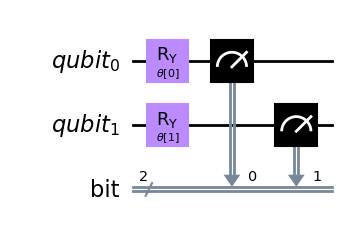

In [33]:
qubit = QuantumRegister(size=2, name="qubit")
bit = ClassicalRegister(size=2, name="bit")
theta = ParameterVector(name=r"$\theta$", length=2)
qc = QuantumCircuit(qubit, bit)
for i in range(2):
    qc.ry(theta=theta[i], qubit=qubit[i])
qc.measure(qubit=qubit, cbit=bit)
qc.draw(output="mpl", style="clifford")

In [34]:
#Definir uma função objetiva 
def objective_circuito(x) -> float:

    qubit = QuantumRegister(size=2, name="qubit")
    theta = ParameterVector(name=r"$\theta$", length=2)
    qc = QuantumCircuit(qubit)
    for i in range(2):
        qc.ry(theta=theta[i], qubit=qubit[i])
    qc = qc.assign_parameters(x)
    backend = Aer.get_backend("statevector_simulator")
    resultado = backend.run(qc).result()
    sv = np.array(resultado.get_statevector())

    cost_function_value = np.real(sv@hamiltonian@sv)

    return cost_function_value

In [37]:
callback_list = []

def callback_func(theta) -> None:
    callback_list.append((theta[0], theta[1], objective_circuito(x=theta)))

x0 = [np.random.random() for _ in range(2)]
resultado = scipy.optimize.minimize(fun=objective_circuito, x0=x0, bounds=None, method="cobyla", callback=callback_func)

In [38]:
#A função deu perto de -12
resultado

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -11.99999994843166
       x: [ 3.141e+00  3.768e-05]
    nfev: 43
   maxcv: 0.0

In [40]:
cost_function_values = []

for theta0 in np.linspace(-2*np.pi, 2*np.pi, 100):
    for theta1 in np.linspace(-2*np.pi, 2*np.pi, 100):

        psi = np.array([np.cos(theta0/2)*np.cos(theta1/2), 
                        np.cos(theta0/2)*np.sin(theta1/2), 
                        np.sin(theta0/2)*np.cos(theta1/2), 
                        np.sin(theta0/2)*np.sin(theta1/2)])
        cost_function_value = psi.T@hamiltonian@psi
        cost_function_values.append(cost_function_value)

In [41]:
cost_function_values_matrix = np.array(cost_function_values).reshape((100, 100))

In [42]:
cost_function_values_matrix.min()

-11.995468881448666

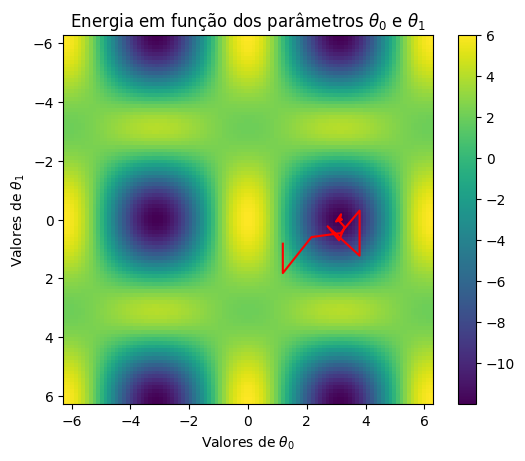

In [43]:
plt.plot([theta0 for theta0, _, _ in callback_list], [theta1 for _, theta1, _ in callback_list], color="red")
plt.imshow(cost_function_values_matrix, extent=(-2*np.pi, 2*np.pi, 2*np.pi, -2*np.pi))
plt.ylabel(r"Valores de $\theta_1$")
plt.xlabel(r"Valores de $\theta_0$")
plt.title(r"Energia em função dos parâmetros $\theta_0$ e $\theta_1$")
plt.colorbar()
plt.show()

In [44]:
surface_plot = go.Surface(x=np.linspace(-2*np.pi, 2*np.pi, 100), y=np.linspace(-2*np.pi, 2*np.pi, 100), z=cost_function_values_matrix, opacity=0.7)
optimizer_path = go.Scatter3d(
    x=[theta0 for theta0, _, _ in callback_list], y=[theta1 for _, theta1, _ in callback_list], z=[np.real(energy) for _, _, energy in callback_list], line=dict(
        color='black',
    )
)
fig = go.Figure(data=[optimizer_path, surface_plot])
fig.show()

In [ ]:
#Quantum Approximate Optimization Algorithm - QAOA - O QAOA é um algoritmo quântico variacional que é inspirado em quantum annealing, cujo objetivo é resolver problemas de otimização combinatória. 


In [45]:
#Encontrando o menor autovalor de H = 5ZZ -3ZI + 4IZ
def cria_circuito_qaoa_exemplo(reps: int=1) -> QuantumCircuit:

    qubit = QuantumRegister(size=2, name="qubit")
    gamma = ParameterVector(name=r"$\gamma$", length=reps)
    beta = ParameterVector(name=r"$\beta$", length=reps)
    qc = QuantumCircuit(qubit)

    qc.h(qubit)
    qc.barrier()
    for i in range(reps):
        qc.rz(hamiltonian[0,0]*gamma[i], qubit[0])
        qc.cx(qubit[0], qubit[1])
        qc.rz(hamiltonian[0,1]*gamma[i], qubit[1])
        qc.cx(qubit[0], qubit[1])
        qc.rz(hamiltonian[1,1]*gamma[i], qubit[1])
        qc.cx(qubit[1], qubit[0])
        qc.rz(hamiltonian[1,0]*gamma[i], qubit[1])
        qc.cx(qubit[1], qubit[0])
        qc.barrier()
        for j in range(2):
            qc.rx(theta=2*beta[i], qubit=qubit[j])

    return qc

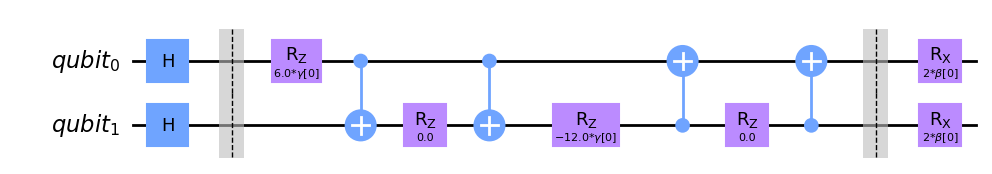

In [46]:
qc = cria_circuito_qaoa_exemplo(reps=1)
qc.draw(output="mpl", style="clifford")

In [47]:
#ESCREVENDO A FUNÇÃO OBEJTIVA PARA O QAOA
def qaoa_objective(params) -> float:

    qc = cria_circuito_qaoa_exemplo(reps=3)
    qc = qc.assign_parameters(params)
    backend = Aer.get_backend("statevector_simulator")
    resultado = backend.run(qc).result()
    sv = resultado.get_statevector()

    cost_function_value = np.real(np.array(sv)@hamiltonian@np.array(sv))

    return cost_function_value

In [48]:
x0 = [2*np.pi for _ in range(6)]
resultado = scipy.optimize.minimize(fun=qaoa_objective, x0=x0, method="cobyla")

In [49]:
resultado

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -11.996055857545922
       x: [ 7.225e+00  5.011e+00  7.829e+00  7.153e+00  8.031e+00
            7.158e+00]
    nfev: 488
   maxcv: 0.0

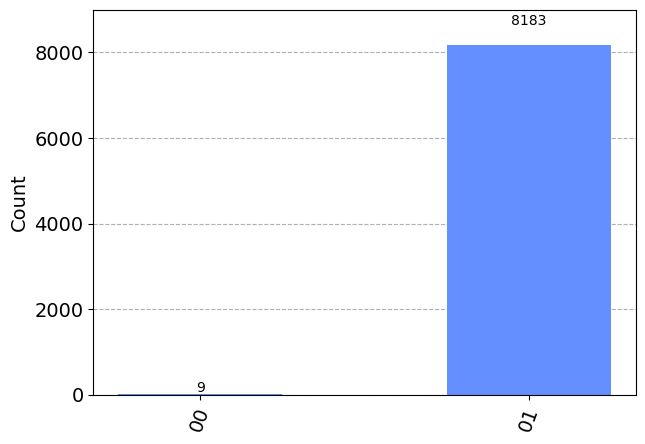

In [50]:
qc = cria_circuito_qaoa_exemplo(reps=3)
qc.measure_all()
qc = qc.assign_parameters(resultado.x)

counts = AerSimulator().run(qc, shots=8192).result().get_counts()

plot_histogram(counts)

In [51]:
def cria_circuito_alternativo_qaoa_exemplo(reps: int=1) -> QuantumCircuit:

    qubit = QuantumRegister(size=2, name="qubit")
    gamma = ParameterVector(name=r"$\gamma$", length=reps)
    beta = ParameterVector(name=r"$\beta$", length=reps)
    qc = QuantumCircuit(qubit)

    qc.h(qubit)
    qc.barrier()
    for i in range(reps):
        qc.rz(hamiltonian[0,0]*gamma[i], qubit[0])
        qc.rzz(theta=hamiltonian[0,1]*gamma[i], qubit1=qubit[0], qubit2=qubit[1])
        qc.rzz(theta=hamiltonian[1,0]*gamma[i], qubit1=qubit[0], qubit2=qubit[1])
        qc.rz(hamiltonian[1,1]*gamma[i], qubit[1])
        qc.barrier()
        for j in range(2):
            qc.rx(theta=2*beta[i], qubit=qubit[j])

    return qc

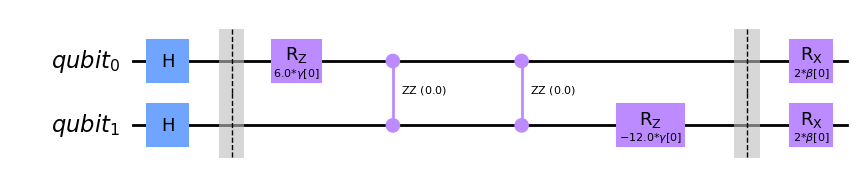

In [52]:
qc = cria_circuito_alternativo_qaoa_exemplo(reps=1)
qc.draw(output="mpl", style="clifford")

In [53]:
def qaoa_objective(params) -> float:

    qc = cria_circuito_alternativo_qaoa_exemplo(reps=3)
    qc = qc.assign_parameters(params)
    backend = Aer.get_backend("statevector_simulator")
    resultado = backend.run(qc).result()
    sv = resultado.get_statevector()

    cost_function_value = np.real(np.array(sv)@hamiltonian@np.array(sv))

    return cost_function_value

In [54]:
x0 = [2*np.pi for _ in range(6)]
resultado = scipy.optimize.minimize(fun=qaoa_objective, x0=x0, method="cobyla")

In [55]:
resultado

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -11.996055857545922
       x: [ 7.225e+00  5.011e+00  7.829e+00  7.153e+00  8.031e+00
            7.158e+00]
    nfev: 488
   maxcv: 0.0

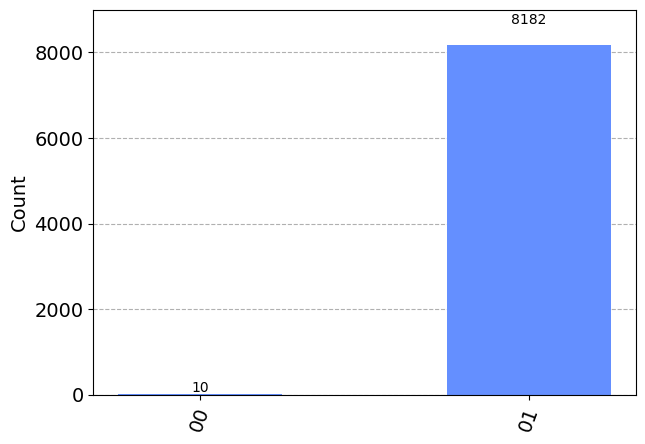

In [56]:
qc = cria_circuito_qaoa_exemplo(reps=3)
qc.measure_all()
qc = qc.assign_parameters(resultado.x)

counts = AerSimulator().run(qc, shots=8192).result().get_counts()

plot_histogram(counts)

In [ ]:
#Knapsack consiste em otimizar o valor total dos itens que serão carreagados em uma mochila e não supere o peso da mochila 

In [57]:
#Escrevendo o problema de otimização proposto acima através da classe Model do DocPLEX da IBM. 
scores_array = np.array([5, 4, 7, 2])
weights_array = np.array([7, 2, 1, 9])
max_capacity = 15

model_knapsack = Model(name="knapsack")

variables_knapsack = np.array([model_knapsack.binary_var(name=f"x_{i}") for i in range(scores_array.shape[0])])

model_knapsack.minimize(-scores_array.T@variables_knapsack)
model_knapsack.add_constraint(weights_array.T@variables_knapsack <= max_capacity)

docplex.mp.LinearConstraint[](7x_0+2x_1+x_2+9x_3,LE,15)

In [58]:
print(model_knapsack.prettyprint())

// This file has been generated by DOcplex
// model name is: knapsack
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;

minimize
 - 5 x_0 - 4 x_1 - 7 x_2 - 2 x_3;
 
subject to {
 7 x_0 + 2 x_1 + x_2 + 9 x_3 <= 15;

}
None


In [59]:
#Transformando a programação inteira linear em um problema inteiro quadratico e em seguida em problema QUBO e depois em Hamiltoniana de Ising
quad_knapsack = from_docplex_mp(model=model_knapsack)

In [60]:
print(quad_knapsack.prettyprint())

Problem name: knapsack

Minimize
  -5*x_0 - 4*x_1 - 7*x_2 - 2*x_3

Subject to
  Linear constraints (1)
    7*x_0 + 2*x_1 + x_2 + 9*x_3 <= 15  'c0'

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [61]:
qubo_knapsack = converter.convert(quad_knapsack)

In [62]:
print(qubo_knapsack.prettyprint())

Problem name: knapsack

Minimize
  19*c0@int_slack@0^2 + 76*c0@int_slack@0*c0@int_slack@1
  + 152*c0@int_slack@0*c0@int_slack@2 + 304*c0@int_slack@0*c0@int_slack@3
  + 76*c0@int_slack@1^2 + 304*c0@int_slack@1*c0@int_slack@2
  + 608*c0@int_slack@1*c0@int_slack@3 + 304*c0@int_slack@2^2
  + 1216*c0@int_slack@2*c0@int_slack@3 + 1216*c0@int_slack@3^2
  + 266*x_0*c0@int_slack@0 + 532*x_0*c0@int_slack@1 + 1064*x_0*c0@int_slack@2
  + 2128*x_0*c0@int_slack@3 + 931*x_0^2 + 532*x_0*x_1 + 266*x_0*x_2
  + 2394*x_0*x_3 + 76*x_1*c0@int_slack@0 + 152*x_1*c0@int_slack@1
  + 304*x_1*c0@int_slack@2 + 608*x_1*c0@int_slack@3 + 76*x_1^2 + 76*x_1*x_2
  + 684*x_1*x_3 + 38*x_2*c0@int_slack@0 + 76*x_2*c0@int_slack@1
  + 152*x_2*c0@int_slack@2 + 304*x_2*c0@int_slack@3 + 19*x_2^2 + 342*x_2*x_3
  + 342*x_3*c0@int_slack@0 + 684*x_3*c0@int_slack@1 + 1368*x_3*c0@int_slack@2
  + 2736*x_3*c0@int_slack@3 + 1539*x_3^2 - 570*c0@int_slack@0
  - 1140*c0@int_slack@1 - 2280*c0@int_slack@2 - 4560*c0@int_slack@3 - 3995*x_0
  - 

In [63]:
ising, offset = qubo_knapsack.to_ising()

In [64]:
ising

SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIZIIZ', 'IIIZIIIZ', 'IIZIIIIZ', 'IZIIIIIZ', 'ZIIIIIIZ', 'IIIIIZZI', 'IIIIZIZI', 'IIIZIIZI', 'IIZIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIIIZZII', 'IIIZIZII', 'IIZIIZII', 'IZIIIZII', 'ZIIIIZII', 'IIIZZIII', 'IIZIZIII', 'IZIIZIII', 'ZIIIZIII', 'IIZZIIII', 'IZIZIIII', 'ZIIZIIII', 'IZZIIIII', 'ZIZIIIII', 'ZZIIIIII'],
              coeffs=[-263.5+0.j,  -74. +0.j,  -34.5+0.j, -341. +0.j,  -38. +0.j,  -76. +0.j,
 -152. +0.j, -304. +0.j,  133. +0.j,   66.5+0.j,  598.5+0.j,   66.5+0.j,
  133. +0.j,  266. +0.j,  532. +0.j,   19. +0.j,  171. +0.j,   19. +0.j,
   38. +0.j,   76. +0.j,  152. +0.j,   85.5+0.j,    9.5+0.j,   19. +0.j,
   38. +0.j,   76. +0.j,   85.5+0.j,  171. +0.j,  342. +0.j,  684. +0.j,
   19. +0.j,   38. +0.j,   76. +0.j,   76. +0.j,  152. +0.j,  304. +0.j])

In [65]:
offset

1112.0

In [66]:
#Criado para saber o valor da resposta e depois comparar se deu certo 
result_knapsack = numpy_solver.compute_minimum_eigenvalue(qubo_knapsack.to_ising()[0])

In [67]:
result_knapsack.eigenvalue + qubo_knapsack.to_ising()[1]

(-16+0j)

In [68]:
result_knapsack.eigenstate.to_dict()

{'01010111': (1+0j)}

In [69]:
answer_knapsack = np.array([int(char) for char in list(result_knapsack.eigenstate.to_dict().keys())[0][::-1]])

In [70]:
answer_knapsack[:-4]

array([1, 1, 1, 0])

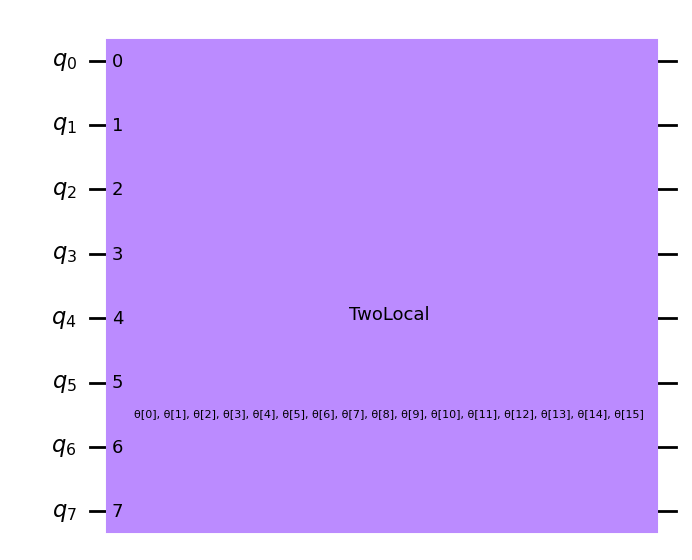

In [71]:
#Criando um ansatz para usar junto ao VQE
ansatz = TwoLocal(num_qubits=8,
                  rotation_blocks=["ry"],
                  entanglement_blocks="cz",
                  entanglement="full",
                  reps=1,
                  skip_final_rotation_layer=False)

ansatz.draw(output="mpl", style="clifford")

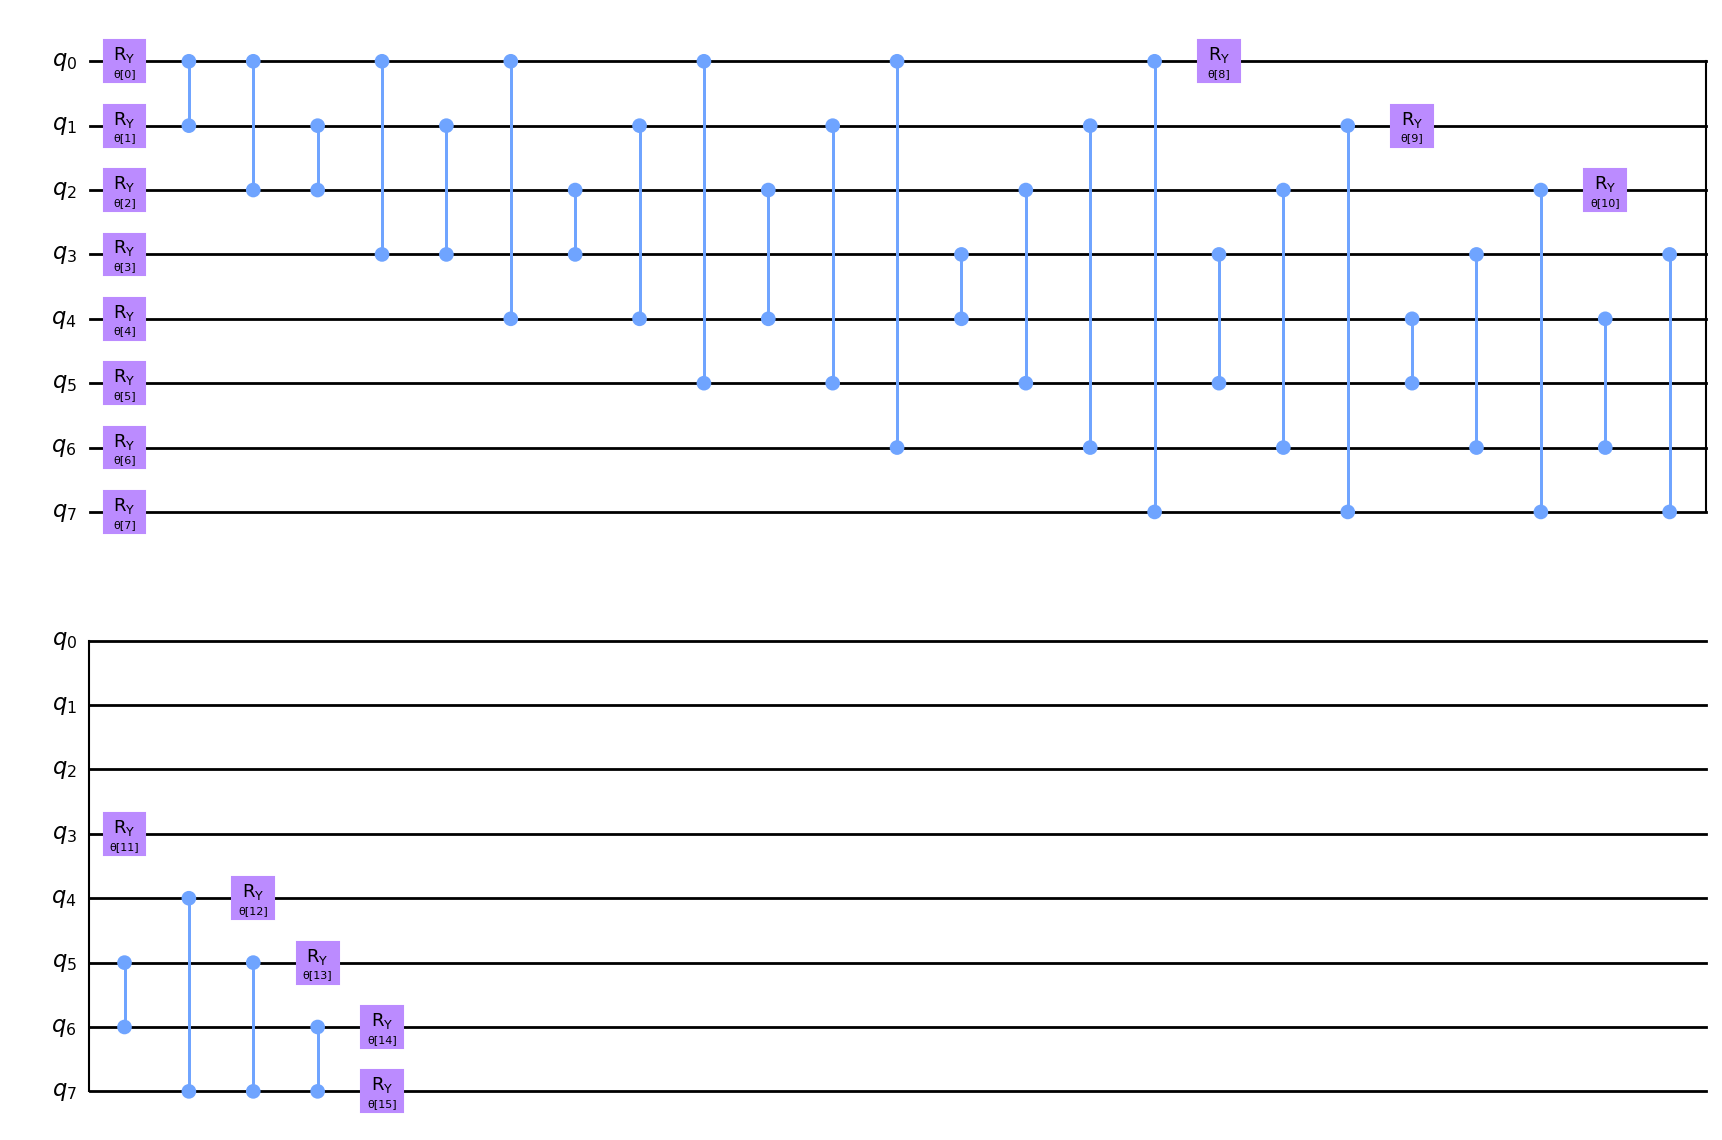

In [72]:
ansatz.decompose().draw(output="mpl", style="clifford")

In [73]:
#Ver a quantidade de portas
ansatz.decompose().count_ops()

OrderedDict([('cz', 28), ('ry', 16)])

In [ ]:
ansatz.decompose().depth()

In [74]:
#Definindo o VQE
initial_point = [1 for _ in range(16)]

vqe_solver = VQE(estimator=Estimator(),
                 ansatz=ansatz,
                 optimizer=COBYLA(maxiter=200),
                 initial_point=initial_point)

In [75]:
#Usando o método compute_minimum_eigenvalue do VQE para calcular o menor autovalor da Hamiltoniana que define o problema

resultado_vqe = vqe_solver.compute_minimum_eigenvalue(qubo_knapsack.to_ising()[0])

In [76]:
#Recuperando o autoestado associado ao valor obtido
ansatz = ansatz.decompose().assign_parameters(resultado_vqe.optimal_parameters)
ansatz.measure_all()
counts = AerSimulator().run(ansatz, shots=8192).result().get_counts()

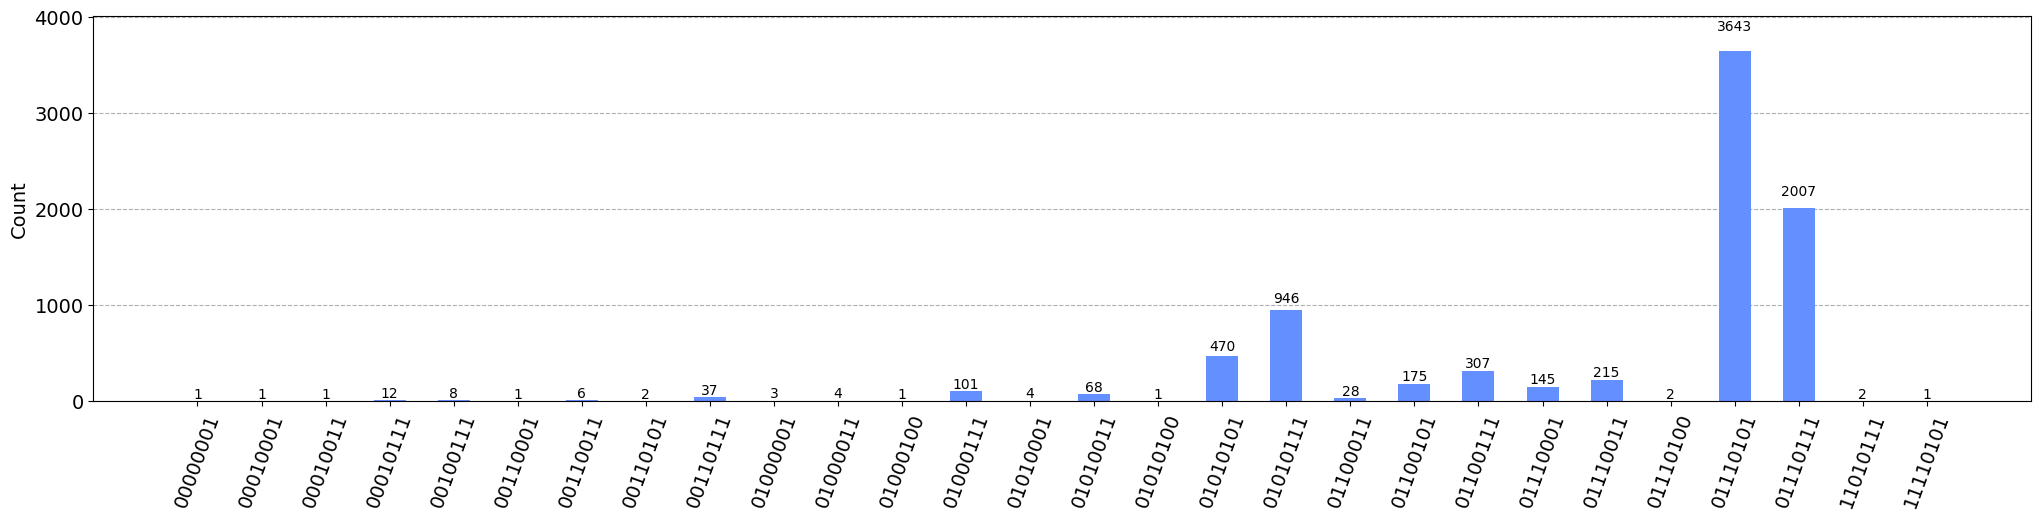

In [77]:
plot_histogram(counts, figsize=(25, 5))

In [78]:
#Pós-processamento
counts_list = list(counts.values())
max_counts = max(counts_list)
max_count_idx = counts_list.index(max_counts)

In [80]:
answer_knapsack_vqe = list(counts.keys())[max_count_idx][::-1]
answer_knapsack_vqe = np.array([int(char) for char in answer_knapsack_vqe[:4]])
print(answer_knapsack_vqe)

[1 0 1 0]


In [81]:
#Definindo a QAOA
initial_point = [np.random.random() for _ in range(2)]

qaoa_solver = QAOA(sampler=Sampler(),
                   optimizer=COBYLA(maxiter=200),
                   reps=1,
                   initial_point=initial_point)

In [82]:
#Usando o método compute_minimum_eigenvalue do QAOA para calcular o menor autovalor da Hamiltoniana que define o problema
resultado_qaoa = qaoa_solver.compute_minimum_eigenvalue(qubo_knapsack.to_ising()[0])

In [83]:
resultado_qaoa.best_measurement

{'state': 87,
 'bitstring': '01010111',
 'value': (-1128+0j),
 'probability': 0.0410346436739737}

In [84]:
answer_knapsack_qaoa = resultado_qaoa.best_measurement["bitstring"][::-1]
answer_knapsack_qaoa = np.array([int(char) for char in answer_knapsack_qaoa[:4]])
print(answer_knapsack_qaoa[:4])

[1 1 1 0]


In [85]:
qc = resultado_qaoa.optimal_circuit
qc = qc.assign_parameters(resultado_qaoa.optimal_parameters)
qc = qc.decompose().decompose()
qc.measure_all()

In [86]:
counts = backend.run(circuits=qc, shots=10**5).result().get_counts()

In [87]:
counts[resultado_qaoa.best_measurement["bitstring"]]

KeyError: '01010111'

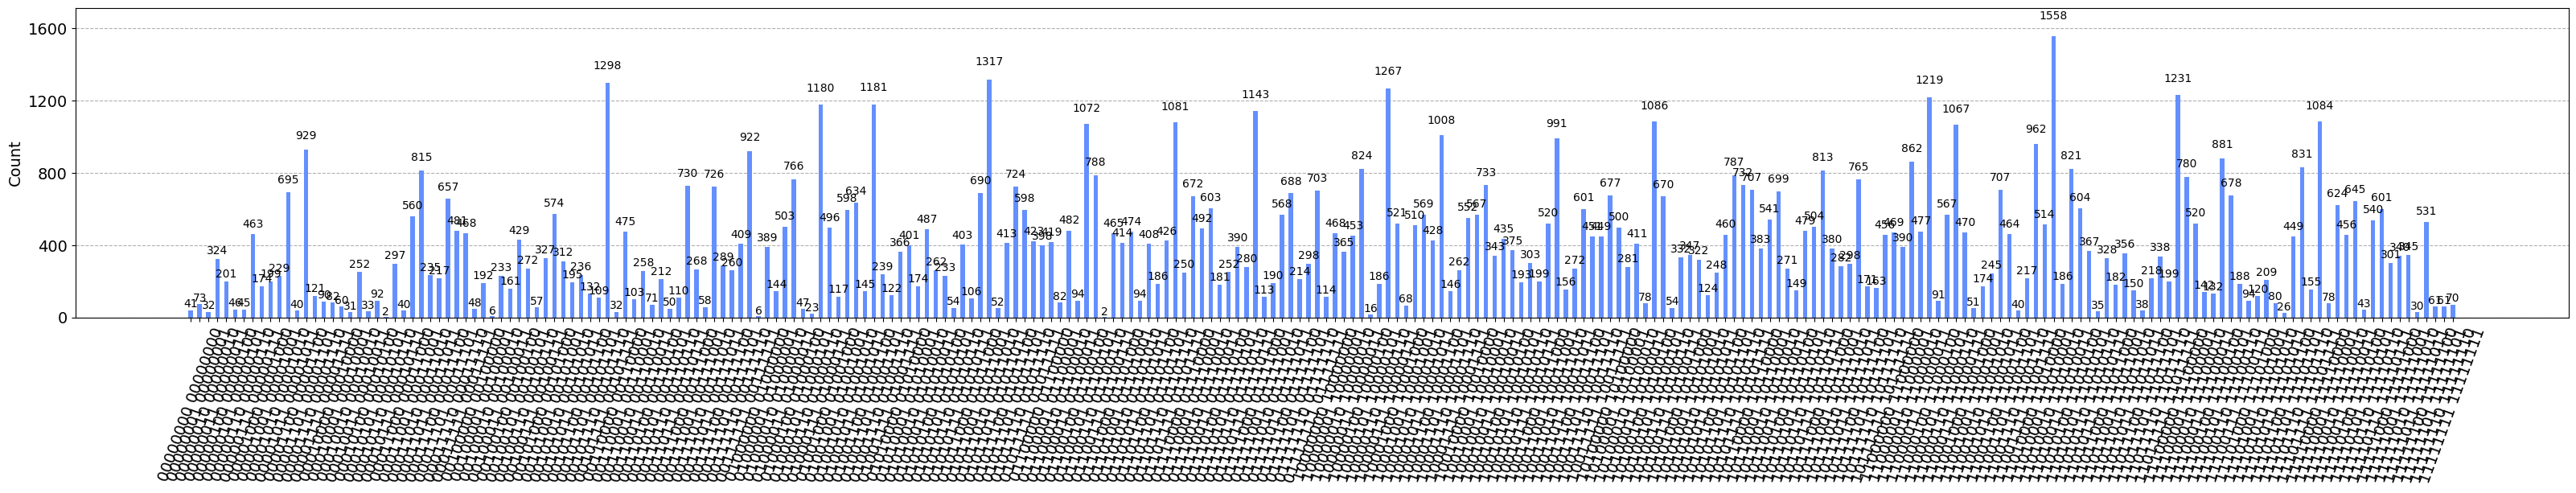

In [88]:
plot_histogram(counts, figsize=(40, 5))

In [89]:
#Uma simulação muito grande com muitas variaveis
scores_array = np.array([np.random.randint(1, 10) for _ in range(55)])
weights_array = np.array([np.random.randint(1, 10) for _ in range(55)])
max_capacity = 15

model_knapsack = Model(name="knapsack")

variables_knapsack = np.array([model_knapsack.binary_var(name=f"x_{i}") for i in range(scores_array.shape[0])])

model_knapsack.minimize(-scores_array.T@variables_knapsack)
model_knapsack.add_constraint(weights_array.T@variables_knapsack <= max_capacity)


docplex.mp.LinearConstraint[](8x_0+8x_1+x_2+9x_3+4x_4+3x_5+5x_6+3x_7+5x_8+3x_9+8x_10+3x_11+3x_12+6x_13+6x_14+x_15+5x_16+9x_17+7x_18+x_19+x_20+5x_21+3x_22+6x_23+6x_24+6x_25+2x_26+9x_27+9x_28+x_29+3x_30+8x_31+4x_32+6x_33+6x_34+2x_35+x_36+9x_37+5x_38+2x_39+8x_40+2x_41+4x_42+x_43+7x_44+4x_45+8x_46+9x_47+8x_48+8x_49+2x_50+4x_51+2x_52+9x_53+x_54,LE,15)

In [90]:
quad_knapsack = from_docplex_mp(model=model_knapsack)

In [91]:
qubo_knapsack = converter.convert(quad_knapsack)

In [92]:
print(qubo_knapsack.prettyprint())

Problem name: knapsack

Minimize
  271*c0@int_slack@0^2 + 1084*c0@int_slack@0*c0@int_slack@1
  + 2168*c0@int_slack@0*c0@int_slack@2 + 4336*c0@int_slack@0*c0@int_slack@3
  + 1084*c0@int_slack@1^2 + 4336*c0@int_slack@1*c0@int_slack@2
  + 8672*c0@int_slack@1*c0@int_slack@3 + 4336*c0@int_slack@2^2
  + 17344*c0@int_slack@2*c0@int_slack@3 + 17344*c0@int_slack@3^2
  + 4336*x_0*c0@int_slack@0 + 8672*x_0*c0@int_slack@1 + 17344*x_0*c0@int_slack@2
  + 34688*x_0*c0@int_slack@3 + 17344*x_0^2 + 34688*x_0*x_1 + 34688*x_0*x_10
  + 13008*x_0*x_11 + 13008*x_0*x_12 + 26016*x_0*x_13 + 26016*x_0*x_14
  + 4336*x_0*x_15 + 21680*x_0*x_16 + 39024*x_0*x_17 + 30352*x_0*x_18
  + 4336*x_0*x_19 + 4336*x_0*x_2 + 4336*x_0*x_20 + 21680*x_0*x_21
  + 13008*x_0*x_22 + 26016*x_0*x_23 + 26016*x_0*x_24 + 26016*x_0*x_25
  + 8672*x_0*x_26 + 39024*x_0*x_27 + 39024*x_0*x_28 + 4336*x_0*x_29
  + 39024*x_0*x_3 + 13008*x_0*x_30 + 34688*x_0*x_31 + 17344*x_0*x_32
  + 26016*x_0*x_33 + 26016*x_0*x_34 + 8672*x_0*x_35 + 4336*x_0*x_36
  +

In [93]:
result_knapsack = numpy_solver.compute_minimum_eigenvalue(qubo_knapsack.to_ising()[0])

MemoryError: Unable to allocate 4.00 EiB for an array with shape (576460752303423488,) and data type uint64

In [94]:
#no Qiskit temos um simulador de MPS (Matrix Product State) que nos permite simular esses cenários com muitos qubits, contudo pode ser que o processo demore um tempo considerável. 
backend = AerSimulator(method="matrix_product_state")
backend_sampler = BackendSampler(backend=backend)

In [95]:
qaoa_solver = QAOA(sampler=backend_sampler,
                   optimizer=COBYLA(maxiter=500),
                   reps=1,
                   initial_point=None)

In [96]:
resultado_qaoa = qaoa_solver.compute_minimum_eigenvalue(qubo_knapsack.to_ising()[0])

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit QAOA-12466 using the matrix_product_state simulator. Required memory: 8796093263872M, max memory: 11855M


QiskitError: 'ERROR:  [Experiment 0] Insufficient memory to run circuit QAOA-12466 using the matrix_product_state simulator. Required memory: 8796093263872M, max memory: 11855M ,  ERROR: Insufficient memory to run circuit QAOA-12466 using the matrix_product_state simulator. Required memory: 8796093263872M, max memory: 11855M'